In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from modules import Sed, get_bandpass_dict
from scipy.interpolate import interp1d
from scipy.signal import medfilt
from scipy.integrate import simps

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

In [3]:
bandpass_dict = get_bandpass_dict()

In [4]:
def idx_closest(x,array):
    return np.fabs(np.array(array)-x).argmin()

def get_continuum(sed,window,buffer=500,order=2):
    
    idxlo1 = idx_closest(window[0]-buffer,sed.wavelen)
    idxhi1 = idx_closest(window[0],sed.wavelen)  
    idxlo2 = idx_closest(window[1],sed.wavelen)
    idxhi2 = idx_closest(window[1]+buffer,sed.wavelen)
    
    x = np.concatenate((sed.wavelen[idxlo1:idxhi1],sed.wavelen[idxlo2:idxhi2]))
    y = np.concatenate((sed.flambda[idxlo1:idxhi1],sed.flambda[idxlo2:idxhi2]))
    
    continuum = np.polynomial.Chebyshev.fit(x,y,deg=order)
    
    return continuum

def get_subtracted(sed,window,buffer=500,order=2):
    
    subtracted = copy.deepcopy(sed)
    
    idxlo = idx_closest(window[0],subtracted.wavelen)
    idxhi = idx_closest(window[1],subtracted.wavelen)
    
    subtracted.flambda[:idxlo] *= 0
    subtracted.flambda[idxhi:] *= 0
    
    continuum = get_continuum(sed,window,buffer,order)
    subtracted.flambda[idxlo:idxhi] -= continuum(subtracted.wavelen[idxlo:idxhi])
    
    return subtracted

def line_photometry(x,wavelen,FWHM=30,maxz=3):
    
    sig = FWHM/2.355
    
    lineSED = Sed(x,0*x)
    gaussian = lambda x: np.exp(-(x-wavelen)**2/(2*sig**2))
    lineSED.flambda += gaussian(lineSED.wavelen)

    wavelens = np.array([])
    fluxes = np.array([])
    for z in np.linspace(0,maxz,500):
        lineSED_ = copy.deepcopy(lineSED)
        lineSED_.redshift(z)
        bands = ['y']
        wavelens_ = [bandpass_dict[band].eff_wavelen/(1+z) for band in bands]
        fluxes_ = lineSED_.fluxlist(bandpass_dict,bands)
        wavelens = np.concatenate((wavelens,wavelens_))
        fluxes = np.concatenate((fluxes,fluxes_))
        
    idx = np.argsort(wavelens)
    wavelens = wavelens[idx]
    fluxes = medfilt(fluxes[idx],kernel_size=11)
    
    f = interp1d(wavelens,fluxes,bounds_error=False,fill_value=0)
    return f 



In [9]:
def spectral_lines(sed,FWHM=30):
    
    # make the SED that will have the spectral lines
    continuum_sed = copy.deepcopy(sed)
    line_sed = copy.deepcopy(sed)
    line_sed.flambda *= 0
    
    sig = FWHM/2.355
    
    # Will go through each spectral line
    # First, will get the SED minus the continuum
    # Then, will calculate the scale factor needed to account for the flux
    # Finally, will subtract the line convolved with the filters,
    # After I have done that for every line, I will add all the lines in
    
    line_dict = {
        "Halpha": { "wavelen": 6563,
                    "window" : [5850,7300],
                    "scale"  : None,
                    "ratio"  : None,
                    "ref"    : None,
                    "buffer" : 500 },
        "Hbeta" : { "wavelen": 4861,
                    "window" : None,
                    "scale"  : None,
                    "ratio"  : 1/2.9,
                    "ref"    : "Halpha",
                    "buffer" : None },
        "O3"    : { "wavelen": 5007,
                    "window" : [4400,5600],
                    "scale"  : None,
                    "ratio"  : None,
                    "ref"    : None,
                    "buffer" : 300 },
        "O2"    : { "wavelen": 3727,
                    "window" : [3300,4200],
                    "scale"  : None,
                    "ratio"  : None,
                    "ref"    : None, 
                    "buffer" : 300}
    }
    
    for line in line_dict:
        
        wavelen, window, scale, ratio, ref, buffer = line_dict[line].values()
        
        if ref != None:
            scale = line_dict[ref]["scale"] * ratio
        else:
            subtracted = get_subtracted(continuum_sed,window,buffer=buffer)
            scale = simps(subtracted.flambda,subtracted.wavelen)/(np.sqrt(2*np.pi)*sig)
          
        scale = np.clip(scale,0,None)
        line_dict[line]["scale"] = scale
        
        f = line_photometry(continuum_sed.wavelen,wavelen,FWHM=FWHM)
        continuum_sed.flambda -= scale*f(continuum_sed.wavelen)
        
        line_sed.flambda += scale * np.exp(-(line_sed.wavelen-wavelen)**2/(2*sig**2))
        
    final_sed = copy.deepcopy(continuum_sed)
    final_sed.flambda += line_sed.flambda
        
    return final_sed, continuum_sed, line_sed

(0, 27)

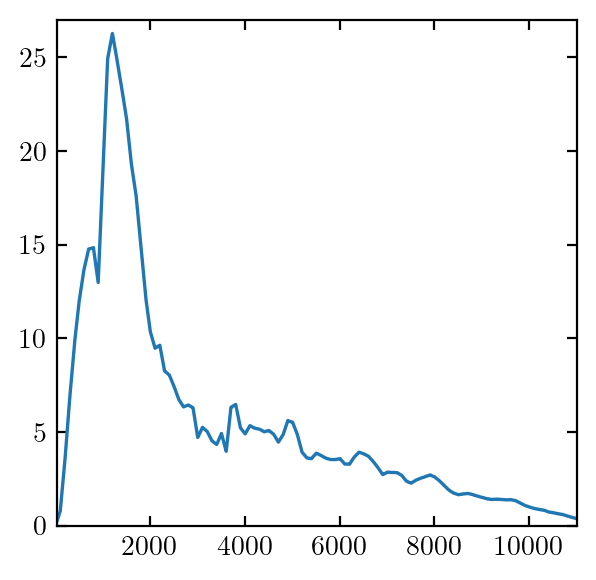

In [10]:
templateN = '16'
x,y = np.loadtxt('templates/naive'+templateN+'_16.sed',unpack=True)

plt.plot(x,y)
plt.xlim(50,11000) 


window = [3300,4200]
window = [5850,7300]

continuum = get_continuum(Sed(x,y),window)
#plt.plot(x,continuum(x))
plt.ylim(0,27)

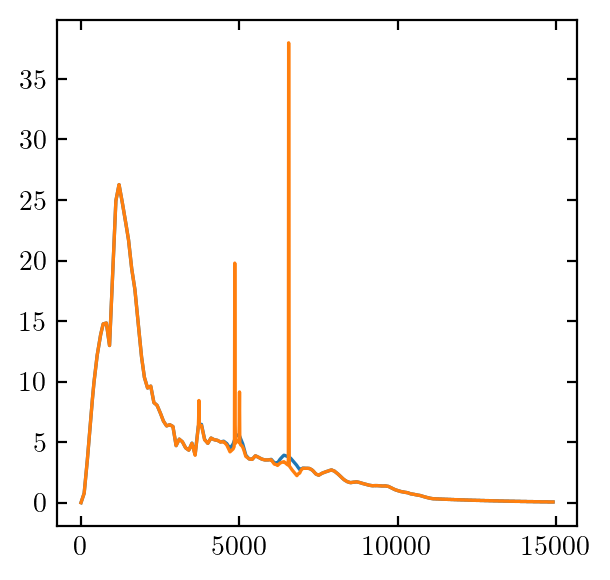

In [13]:
final_sed, continuum_sed, line_sed = spectral_lines(Sed(x,y),FWHM=10)

plt.plot(x,y)

plt.plot(final_sed.wavelen,final_sed.flambda)
#plt.xlim(4000,6000)

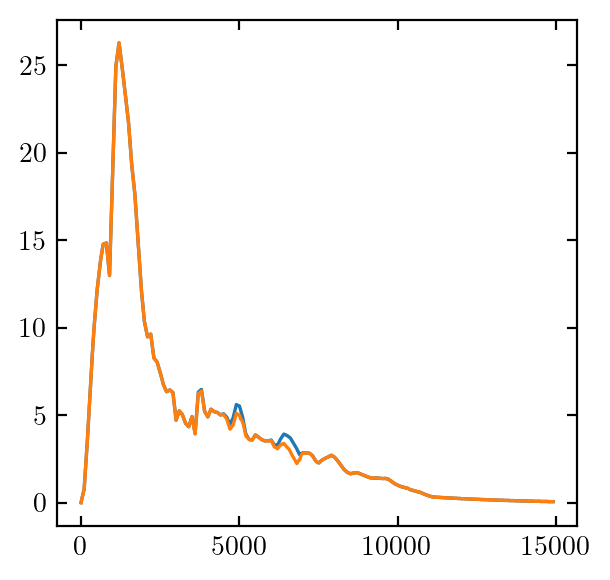

In [14]:
plt.plot(x,y)
plt.plot(continuum_sed.wavelen,continuum_sed.flambda)